In [1]:
#Mod4 Final Project Forcasting Stock Prices with a Neural Network


In [49]:
import numpy as np
import pandas as pd
import pandas.tseries
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import random
import warnings
warnings.filterwarnings("ignore")


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression



from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier ,RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report ,precision_score, recall_score, accuracy_score

import xgboost as xgb

import itertools

import statsmodels.api as sm
import statsmodels.discrete.discrete_model as sm

from patsy import dmatrices

import keras
from keras import models
from keras import layers
from keras import optimizers
from keras.layers import LSTM, GRU, Dense, GlobalMaxPool1D, Embedding, Dropout
from keras.preprocessing import text, sequence
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

In [50]:

df = pd.read_csv('all_stocks_5yr.csv')

index = pd.to_datetime(df.date)
df = df.set_index(index)
df.dropna(inplace=True)
short_df = df
df['Difference']=  df['open'] - df['close']

df['Viable'] = df.Difference.apply(lambda x: 1 if x >0 else 0)
df['Rolling_Vitality'] = df['Viable'].rolling(5).sum()/5
df['Roll_sum_bkfill'] = df['Rolling_Vitality'].fillna(method='backfill')
df['Daily_Average'] =df['Viable'].resample('d').mean()
df['Market_Viable'] = df.Daily_Average.apply(lambda x: 1 if x >.5 else 0)
df['Rolling_Market'] = df['Daily_Average'].rolling(5).sum()/5
df['Roll_Mark_bkf'] = df['Rolling_Market'].fillna(method='backfill')

#Setting Target as Tomorrows Viablity 

df['Yesterday_Market']= df.Market_Viable.shift(1).fillna(method='backfill')
df['Market_2days_ago'] = df.Market_Viable.shift(2).fillna(method='backfill')
df['Market_3days_ago'] = df.Market_Viable.shift(3).fillna(method='backfill')
df['Market_4days_ago'] = df.Market_Viable.shift(4).fillna(method='backfill')
df['Market_Average'] = (df['Yesterday_Market'] + df['Market_2days_ago'] + df['Market_3days_ago'] + df['Market_4days_ago'] ) / 4
df['Yesteday_Vitality'] = df.Viable.shift(1).fillna(method='backfill')
df['Vitality_2days_ago'] = df.Viable.shift(2).fillna(method='backfill')
df['Vitality_3days_ago'] = df.Viable.shift(3).fillna(method='backfill')
df['Vitality_4days_ago'] = df.Viable.shift(4).fillna(method='backfill')
df['Vitality_Average']= (df['Yesteday_Vitality'] + df['Vitality_2days_ago'] + df['Vitality_3days_ago'] + df['Vitality_4days_ago'] ) / 4

df['Market_5days_ago'] = df.Market_Viable.shift(5).fillna(method='backfill')
df['Market_6days_ago'] = df.Market_Viable.shift(6).fillna(method='backfill')
df['Market_7days_ago'] = df.Market_Viable.shift(7).fillna(method='backfill')


df['Vitality_5days_ago'] = df.Viable.shift(5).fillna(method='backfill')
df['Vitality_6days_ago'] = df.Viable.shift(6).fillna(method='backfill')
df['Vitality_7days_ago'] = df.Viable.shift(7).fillna(method='backfill')


In [ ]:
#Exploring Data 

In [42]:
df.head()

,date,open,high,low,close,volume,Name,Difference,Viable,Rolling_Vitality,...,Yesterday_Market,Market_2days_ago,Market_3days_ago,Market_4days_ago,Market_Average,Yesteday_Vitality,Vitality_2days_ago,Vitality_3days_ago,Vitality_4days_ago,Vitality_Average
date,,,,,,,,,,,,,,,,,,,,,
2013-02-08,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL,0.32,1,NaN,...,0.0,0.0,0.0,0.0,0.00,1.0,1.0,1.0,1.0,1.00
2013-02-11,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL,0.43,1,NaN,...,0.0,0.0,0.0,0.0,0.00,1.0,1.0,1.0,1.0,1.00
2013-02-12,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL,0.18,1,NaN,...,1.0,0.0,0.0,0.0,0.25,1.0,1.0,1.0,1.0,1.00
2013-02-13,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL,-0.36,0,NaN,...,0.0,1.0,0.0,0.0,0.25,1.0,1.0,1.0,1.0,1.00
2013-02-14,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL,0.95,1,0.8,...,1.0,0.0,1.0,0.0,0.50,0.0,1.0,1.0,1.0,0.75


In [59]:
df.describe()

,open,high,low,close,volume,Viable,Yesterday_Market,Market_2days_ago,Market_3days_ago,Market_4days_ago,Yesteday_Vitality,Vitality_2days_ago,Vitality_3days_ago,Vitality_4days_ago,Market_5days_ago,Market_6days_ago,Market_7days_ago,Vitality_5days_ago,Vitality_6days_ago,Vitality_7days_ago
count,619029.000000,619029.000000,619029.000000,619029.000000,6.190290e+05,619029.000000,619029.000000,619029.000000,619029.000000,619029.000000,619029.000000,619029.000000,619029.000000,619029.000000,619029.000000,619029.000000,619029.000000,619029.000000,619029.000000,619029.000000
mean,83.023334,83.778419,82.256200,83.043305,4.321892e+06,0.476596,0.433561,0.433561,0.433560,0.433558,0.476598,0.476600,0.476600,0.476600,0.433558,0.433556,0.433555,0.476601,0.476601,0.476601
std,97.378769,98.207735,96.507634,97.388913,8.693671e+06,0.499452,0.495567,0.495567,0.495566,0.495566,0.499452,0.499453,0.499453,0.499453,0.495566,0.495566,0.495566,0.499453,0.499453,0.499453
min,1.620000,1.690000,1.500000,1.590000,1.010000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.220000,40.620000,39.830000,40.240800,1.070351e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,62.590000,63.150000,62.020000,62.620000,2.082165e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,94.370000,95.180000,93.540000,94.410000,4.284550e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [353]:
year_groups = df.open.groupby(pd.Grouper(freq ='A'))
price_annual = pd.DataFrame()


date
2013-12-31    AxesSubplot(0.125,0.2;0.775x0.68)
2014-12-31    AxesSubplot(0.125,0.2;0.775x0.68)
2015-12-31    AxesSubplot(0.125,0.2;0.775x0.68)
2016-12-31    AxesSubplot(0.125,0.2;0.775x0.68)
2017-12-31    AxesSubplot(0.125,0.2;0.775x0.68)
2018-12-31    AxesSubplot(0.125,0.2;0.775x0.68)
Freq: A-DEC, Name: open, dtype: object

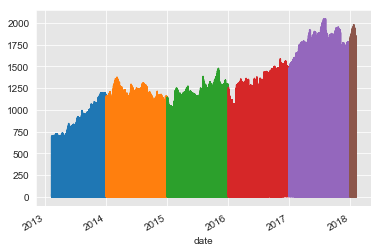

In [354]:
year_groups.plot()

 Logistica Regression Accuracy  0.5232104317708939
Residual Value Count 
0    80971
1    73787
dtype: int64
Normalized Residual Values 
0    0.52321
1    0.47679
dtype: float64


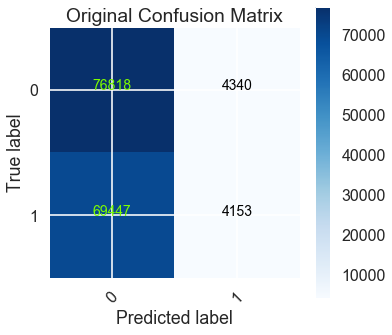

In [113]:
y, X = dmatrices('Viable ~  Vitality_Average +Market_Average   +Yesterday_Market +  Yesteday_Vitality + Market_2days_ago + Market_3days_ago + Market_4days_ago + Market_5days_ago + Market_6days_ago + Market_7days_ago + Vitality_2days_ago  + Vitality_3days_ago  + Vitality_4days_ago + Vitality_5days_ago  + Vitality_6days_ago  + Vitality_7days_ago', short_df, return_type = "dataframe")        

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

#Base Log Regression
logreg = LogisticRegression(fit_intercept = False, C = 1e12)
model_log = logreg.fit(X_train, y_train)
y_hat_test = logreg.predict(X_test)
y_hat_train = logreg.predict(X_train)
model_score = model_log.score( X_test, y_test)
#print(f' Logistica Regression Accuracy  {model_score}')

X= X.dropna()
y = df.Viable
y = y.dropna()
#y= y.iloc[:40000,:]
r = np.ravel(y)

y= r
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
logreg = LogisticRegression(fit_intercept = False, C = 1e12)
model_log = logreg.fit(X_train, y_train)
y_hat_test = logreg.predict(X_test)
y_hat_train = logreg.predict(X_train)
score = logreg.score(X_test, y_test)


predictions = logreg.predict(X_test)
y_hat_train = logreg.predict(X_train)
residuals = np.abs(y_test - y_hat_test)
print(f'Residual Value Count \n{pd.Series(residuals).value_counts()}')
print(f'Normalized Residual Values \n{pd.Series(residuals).value_counts(normalize=True)}')
#Create the basic matrix.
cnf_matrix = confusion_matrix(y_test, predictions)



#Confusion Matrix graphic
plt.figure(figsize =(5,5))
plt.imshow(cnf_matrix,  cmap=plt.cm.Blues) #Create the basic matrix.
#Add title and Axis Labels
plt.title('Original Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

#Add appropriate Axis Scales
class_names = set(y) #Get class labels to add to matrix
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

#Add Labels to Each Cell
thresh = cnf_matrix.max() / 4 #Used for text coloring below
#Here we iterate through the confusion matrix and append labels to our visualization.
for  i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text( j,i,  cnf_matrix[i, j],
                 horizontalalignment="center",
                 color="lawngreen" if cnf_matrix[i, j] > thresh else "black")

#Add a Side Bar Legend Showing Colors
plt.colorbar()

Logistic Regeression score 0.5232104317708939
Residual Value Count 
0    82538
1    79463
dtype: int64
Normalized Residual Values 
0    0.509491
1    0.490509
dtype: float64


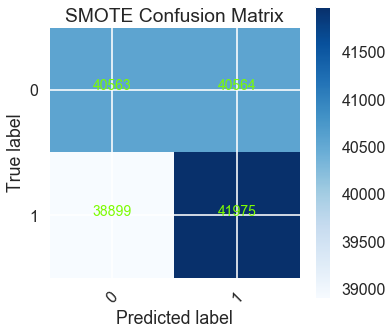

In [101]:
#Synthetic Minority Oversampling Technique to balance Confusion Matrix


from imblearn.over_sampling import SMOTE 

sm = SMOTE()
X, y = sm.fit_sample(X, y)


r = np.ravel(y)
y= r
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
logreg = LogisticRegression(fit_intercept = False, C = 1e12)
model_log = logreg.fit(X_train, y_train)
y_hat_test = logreg.predict(X_test)
y_hat_train = logreg.predict(X_train)

residuals = np.abs(y_train - y_hat_train)

print(f'Logistic Regeression score {score}')
predictions = logreg.predict(X_test)
y_hat_train = logreg.predict(X_train)
residuals = np.abs(y_test - y_hat_test)
print(f'Residual Value Count \n{pd.Series(residuals).value_counts()}')
print(f'Normalized Residual Values \n{pd.Series(residuals).value_counts(normalize=True)}')
#Create the basic matrix.
cnf_matrix = confusion_matrix(y_test, predictions)



#Confusion Matrix graphic
plt.figure(figsize =(5,5))
plt.imshow(cnf_matrix,  cmap=plt.cm.Blues) #Create the basic matrix.
#Add title and Axis Labels
plt.title('SMOTE Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

#Add appropriate Axis Scales
class_names = set(y) #Get class labels to add to matrix
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

#Add Labels to Each Cell
thresh = cnf_matrix.max() / 1.8 #Used for text coloring below
#Here we iterate through the confusion matrix and append labels to our visualization.
for  i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text( j,i,  cnf_matrix[i, j],
                 horizontalalignment="center",
                 color="lawngreen" if cnf_matrix[i, j] > thresh else "black")

#Add a Side Bar Legend Showing Colors
plt.colorbar()


In [ ]:
#Shallow Machine Learning and Modeling 

In [124]:
logreg = LogisticRegression(fit_intercept = False, C = 1e12)
logreg

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [126]:
logreg = LogisticRegression(fit_intercept = False, C = 1e12)
model_log = logreg.fit(X_train, y_train)
model_score = logreg.score(X_test, y_test)
model_score

0.5232104317708939

In [118]:
classifier = DecisionTreeClassifier(random_state=10, criterion = 'entropy') 
classifier

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')

In [117]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(random_state=10, criterion = 'entropy')  
classifier.fit(X_train, y_train) 
classifier.score(X_test, y_test)

0.5588144070096538

In [119]:
#Random Forest Classifier
clf = RandomForestClassifier(random_state=0, n_jobs=-1)
clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [123]:
# Create Random Forest decision tree classifer object
clf = RandomForestClassifier(random_state=0, n_jobs=-1)

# Train model
model_clf = clf.fit(X, y)
print(f'Accuracy of Random Forest : {clf.score(X,y)}')
print(' ')

importances = clf.feature_importances_
#print(X.columns, importances)




Accuracy of Random Forest : 0.5936442396075143
 


In [66]:
#XGBoost Classifier
clf = xgb.XGBClassifier()
clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

Original Results
Precision = 0.5381926725293742
Recall = 0.51648611733737
Accuracy = 0.53254284929648


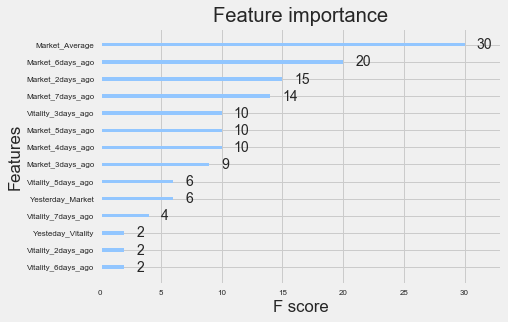

In [67]:
# Checking Feature Importance
clf = xgb.XGBClassifier()
clf
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)



param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 3} 

steps = 10  # The number of training iterations

bias_model = xgb.train(param, D_train, steps)
preds = bias_model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])
print('Original Results')
print("Precision = {}".format(precision_score(y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))

xgb.plot_importance(bias_model)


In [285]:
#Gradient Boosting
gbt_clf = GradientBoostingClassifier()
gbt_clf

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [115]:
#Gradient Boosting

gbt_clf = GradientBoostingClassifier()
gbt_clf.fit(X_train, y_train)
gbt_clf_train_preds = gbt_clf.predict(X_train)
gbt_clf_test_preds = gbt_clf.predict(X_test)

def display_acc_and_f1_score(true, preds, model_name):
    acc = accuracy_score(true, preds)
    f1 = f1_score(true, preds)
    print("Model: {}".format(model_name))
    print("Accuracy: {}".format(acc))
    print("F1-Score: {}".format(f1))
    
print("Training Metrics")
display_acc_and_f1_score(y_train, gbt_clf_train_preds, model_name='Gradient Boosted Trees')
print("")
print("Testing Metrics")

print("")
display_acc_and_f1_score(y_test, gbt_clf_test_preds, model_name='Gradient Boosted Trees')



Training Metrics
Model: Gradient Boosted Trees
Accuracy: 0.5376730400994247
F1-Score: 0.3375747232500795

Testing Metrics

Model: Gradient Boosted Trees
Accuracy: 0.5371677070006075
F1-Score: 0.33553809475217306


AUC: 0.5151741169353372


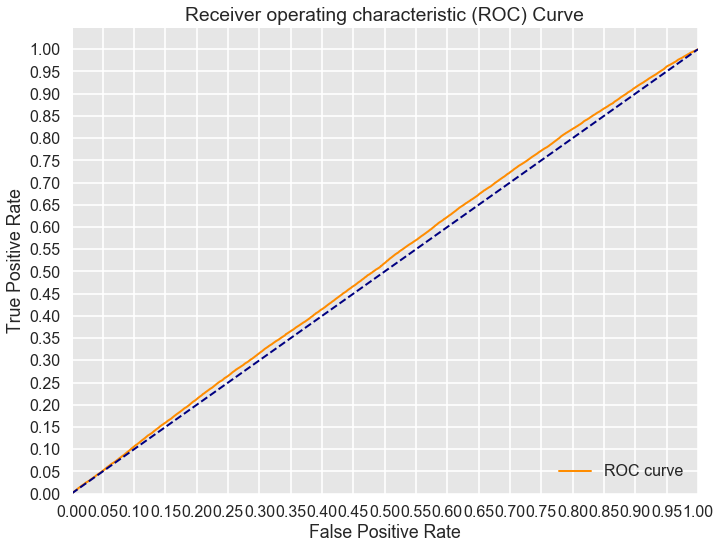

In [81]:
#Find the probability of test points
from sklearn.metrics import accuracy_score, roc_curve, auc
y_score = logreg.fit(X_train, y_train).decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#Deep Learning and Neural Networks


In [51]:
# LSTM Neural Networks
# split into train and test sets

df = df.drop(['Name', 'date', 'Rolling_Vitality','Difference','Roll_sum_bkfill','Daily_Average','Market_Viable','Market_Average','Rolling_Market','Roll_Mark_bkf', 'Vitality_Average'], axis =1)
# split into input and outputs
train_X, train_y = df.iloc[:488206, 6:], df.iloc[:488206,5]
test_X, test_y = df.iloc[488206:, 6:], df.iloc[488206:,5]
# converting from dataframe to arrary 
test_X, test_y = test_X.values, test_y.values
train_X, train_y = train_X.values, train_y.values
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(488206, 1, 14) (488206,) (130823, 1, 14) (130823,)


In [127]:
  
model_bc = Sequential()
model_bc

In [37]:
#Neural Network Keras Sequential
#design loss = binary_crossentropy, optimizer = adam ,  metrics= accuracy 
model_bc = Sequential()
model_bc.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model_bc.add(Dense(1))
model_bc.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# early stopping to prevent over-fitting
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0)


# fit network
history_bc = model_bc.fit(train_X, train_y, epochs=15, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False,  callbacks = [es] )




Train on 488206 samples, validate on 130823 samples
Epoch 1/15
 - 31s - loss: 0.7038 - acc: 0.5191 - val_loss: 0.6927 - val_acc: 0.5138
Epoch 2/15
 - 30s - loss: 0.6913 - acc: 0.5262 - val_loss: 0.6915 - val_acc: 0.5234
Epoch 3/15
 - 30s - loss: 0.6905 - acc: 0.5307 - val_loss: 0.6903 - val_acc: 0.5333
Epoch 4/15
 - 29s - loss: 0.6895 - acc: 0.5350 - val_loss: 0.6890 - val_acc: 0.5376
Epoch 5/15
 - 30s - loss: 0.6884 - acc: 0.5381 - val_loss: 0.6880 - val_acc: 0.5408
Epoch 6/15
 - 30s - loss: 0.6874 - acc: 0.5419 - val_loss: 0.6871 - val_acc: 0.5438
Epoch 7/15
 - 30s - loss: 0.6866 - acc: 0.5446 - val_loss: 0.6864 - val_acc: 0.5471
Epoch 8/15
 - 30s - loss: 0.6859 - acc: 0.5470 - val_loss: 0.6859 - val_acc: 0.5489
Epoch 9/15
 - 30s - loss: 0.6854 - acc: 0.5488 - val_loss: 0.6854 - val_acc: 0.5509
Epoch 10/15
 - 29s - loss: 0.6849 - acc: 0.5504 - val_loss: 0.6850 - val_acc: 0.5511
Epoch 11/15
 - 30s - loss: 0.6845 - acc: 0.5519 - val_loss: 0.6847 - val_acc: 0.5510
Epoch 12/15
 - 30s - l

In [38]:
# Model Results of Binary Cross-Entropy with Adam Optimizer  
print("Model Evaluation Accuracy of Binary Cross-Entropy")
print(model_bc.evaluate(test_X, test_y))
print('Model Summary')
model_bc.summary()

Model Evaluation Accuracy of Binary Cross-Entropy
130823/130823 [==============================] - 6s 48us/step
[0.6836562581937203, 0.5532742713446351]
Model Summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 50)                13000     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 51        
Total params: 13,051
Trainable params: 13,051
Non-trainable params: 0
_________________________________________________________________


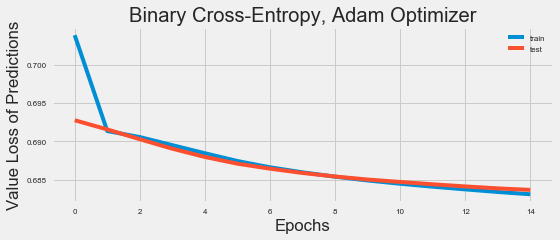

In [39]:
# Display Results Binary Cross-Entropy With Adam optimizer
plt.style.use('fivethirtyeight')
plt.figure(figsize= (8,3))
plt.plot(history_bc.history['loss'], label='train')
plt.plot(history_bc.history['val_loss'], label='test')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Value Loss of Predictions')
plt.title('Binary Cross-Entropy, Adam Optimizer')
plt.show()




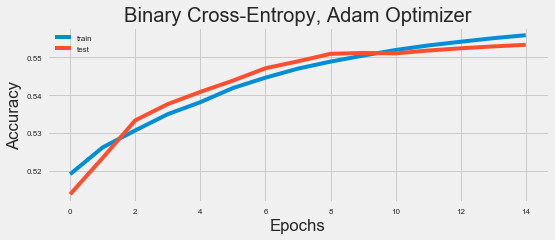

In [40]:
# Display Results Binary Cross-Entropy With Adam optimizer
plt.style.use('fivethirtyeight')
plt.figure(figsize= (8,3))
plt.plot(history_bc.history['acc'], label='train')
plt.plot(history_bc.history['val_acc'], label='test')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Binary Cross-Entropy, Adam Optimizer')
plt.show()




In [41]:
# Early Stopping was blocked to compare Adam Optimizer Against Stochastic Gradient Descent  
model_bc_sgd = Sequential()
model_bc_sgd.add(LSTM(10, input_shape=(train_X.shape[1], train_X.shape[2])))
model_bc_sgd.add(Dense(1))
model_bc_sgd.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=0)
# fit network
history_bc_sgd = model_bc_sgd.fit(train_X, train_y, epochs=15, batch_size=72, validation_data=(test_X, test_y))





Train on 488206 samples, validate on 130823 samples
Epoch 1/15
488206/488206 [==============================] - 33s 68us/step - loss: 0.6961 - acc: 0.5138 - val_loss: 0.6923 - val_acc: 0.5210
Epoch 2/15
488206/488206 [==============================] - 31s 64us/step - loss: 0.6924 - acc: 0.5193 - val_loss: 0.6919 - val_acc: 0.5238
Epoch 3/15
488206/488206 [==============================] - 31s 64us/step - loss: 0.6921 - acc: 0.5218 - val_loss: 0.6917 - val_acc: 0.5256
Epoch 4/15
488206/488206 [==============================] - 32s 65us/step - loss: 0.6918 - acc: 0.5229 - val_loss: 0.6918 - val_acc: 0.5208
Epoch 5/15
488206/488206 [==============================] - 32s 65us/step - loss: 0.6916 - acc: 0.5238 - val_loss: 0.6914 - val_acc: 0.5269
Epoch 6/15
488206/488206 [==============================] - 33s 67us/step - loss: 0.6915 - acc: 0.5247 - val_loss: 0.6913 - val_acc: 0.5269
Epoch 7/15
488206/488206 [==============================] - 32s 65us/step - loss: 0.6914 - acc: 0.5261 - val

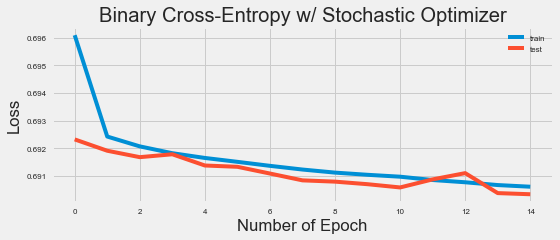

In [44]:
# Display Loss Results Binary Cross-Entropy With Stochastic optimizer
plt.figure(figsize = (8,3))
plt.plot(history_bc_sgd.history['loss'], label='train')
plt.plot(history_bc_sgd.history['val_loss'], label='test')
plt.legend()
plt.title('Binary Cross-Entropy w/ Stochastic Optimizer')
plt.ylabel('Loss')
plt.xlabel('Number of Epoch')
plt.show()

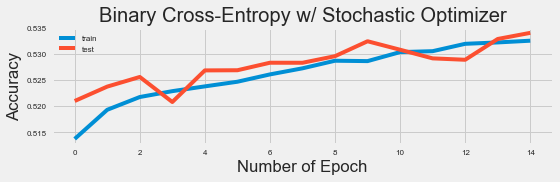

In [45]:
# Display Accuracy Results Binary Cross-Entropy With Stochastic optimizer
plt.figure(figsize = (8,2))
plt.plot(history_bc_sgd.history['acc'], label='train')
plt.plot(history_bc_sgd.history['val_acc'], label='test')
plt.legend()
plt.title('Binary Cross-Entropy w/ Stochastic Optimizer')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epoch')
plt.show()

In [5]:
# Increased Number of Epoch as accuracy appears to be increasing past Epoch 15
model_bc_sgd = Sequential()
model_bc_sgd.add(LSTM(10, input_shape=(train_X.shape[1], train_X.shape[2])))
model_bc_sgd.add(Dense(1))
model_bc_sgd.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=0)
# fit network
history_bc_sgd_long = model_bc_sgd.fit(train_X, train_y, epochs=30, batch_size=72, validation_data=(test_X, test_y))




Train on 488206 samples, validate on 130823 samples
Epoch 1/30
488206/488206 [==============================] - 30s 61us/step - loss: 0.6945 - acc: 0.5180 - val_loss: 0.6918 - val_acc: 0.5209
Epoch 2/30
488206/488206 [==============================] - 30s 61us/step - loss: 0.6921 - acc: 0.5211 - val_loss: 0.6917 - val_acc: 0.5231
Epoch 3/30
488206/488206 [==============================] - 30s 61us/step - loss: 0.6919 - acc: 0.5226 - val_loss: 0.6923 - val_acc: 0.5162
Epoch 4/30
488206/488206 [==============================] - 30s 61us/step - loss: 0.6918 - acc: 0.5224 - val_loss: 0.6915 - val_acc: 0.5245
Epoch 5/30
488206/488206 [==============================] - 35s 72us/step - loss: 0.6917 - acc: 0.5228 - val_loss: 0.6913 - val_acc: 0.5241
Epoch 6/30
488206/488206 [==============================] - 31s 63us/step - loss: 0.6916 - acc: 0.5237 - val_loss: 0.6913 - val_acc: 0.5259
Epoch 7/30
488206/488206 [==============================] - 34s 70us/step - loss: 0.6916 - acc: 0.5241 - val

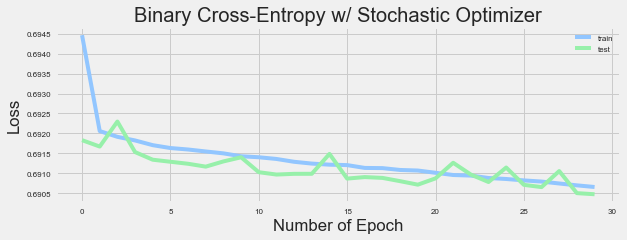

In [53]:
# Display Loss Results Binary Cross-Entropy With Stochastic optimizer
plt.figure(figsize = (9,3))
plt.plot(history_bc_sgd_long.history['loss'], label='train')
plt.plot(history_bc_sgd_long.history['val_loss'], label='test')
plt.legend()
plt.style.use('seaborn-pastel')
plt.title('Binary Cross-Entropy w/ Stochastic Optimizer')
plt.ylabel('Loss')
plt.xlabel('Number of Epoch')
plt.show()

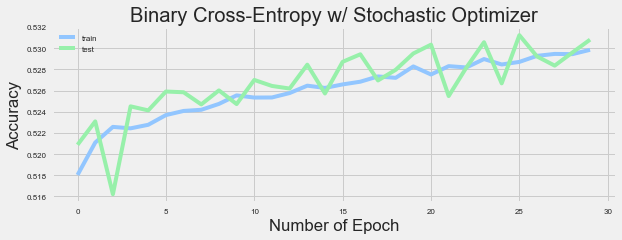

In [54]:
# Display Accuracy Results Binary Cross-Entropy With Stochastic optimizer
plt.figure(figsize = (9,3))
plt.plot(history_bc_sgd_long.history['acc'], label='train')
plt.plot(history_bc_sgd_long.history['val_acc'], label='test')
plt.legend()
plt.title('Binary Cross-Entropy w/ Stochastic Optimizer')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epoch')
plt.show()

In [8]:
# Model Binary Cross-Entropy With Stochastic optimizer Results 
print("Model Evaluation Binary Cross Loss SGD Optimizer")
print(model_bc_sgd_long.evaluate(test_X, test_y))
print('Model Summary')
model_bc_sgd.summary()

Model Evaluation Binary Cross Loss SGD Optimizer
130823/130823 [==============================] - 6s 42us/step
[0.6904723002735422, 0.5308088027343755]
Model Summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10)                1000      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 1,011
Trainable params: 1,011
Non-trainable params: 0
_________________________________________________________________


In [56]:
# Use of Relu activation 
#design loss = binary_crossentropy, optimizer = adam ,  metrics= accuracy 
model_relu = Sequential()
model_relu.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model_relu.add(LSTM(50, activation='relu'))
model_relu.add(Dense(64))
model_relu.add(Dense(1))
model_relu.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
# early stopping to prevent over-fitting
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience = 5)

# fit network
history__relu = model_relu.fit(train_X, train_y, epochs=20, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks= [es])




Train on 488206 samples, validate on 130823 samples
Epoch 1/20
 - 52s - loss: 0.6948 - acc: 0.5266 - val_loss: 0.6905 - val_acc: 0.5314
Epoch 2/20
 - 47s - loss: 0.6884 - acc: 0.5392 - val_loss: 0.6874 - val_acc: 0.5420
Epoch 3/20
 - 47s - loss: 0.6857 - acc: 0.5475 - val_loss: 0.6861 - val_acc: 0.5484
Epoch 4/20
 - 48s - loss: 0.6842 - acc: 0.5515 - val_loss: 0.6849 - val_acc: 0.5503
Epoch 5/20
 - 48s - loss: 0.6832 - acc: 0.5537 - val_loss: 0.6846 - val_acc: 0.5511
Epoch 6/20
 - 48s - loss: 0.6825 - acc: 0.5552 - val_loss: 0.6842 - val_acc: 0.5515
Epoch 7/20
 - 47s - loss: 0.6819 - acc: 0.5562 - val_loss: 0.6838 - val_acc: 0.5528
Epoch 8/20
 - 47s - loss: 0.6815 - acc: 0.5576 - val_loss: 0.6832 - val_acc: 0.5548
Epoch 9/20
 - 47s - loss: 0.6810 - acc: 0.5590 - val_loss: 0.6827 - val_acc: 0.5550
Epoch 10/20
 - 48s - loss: 0.6807 - acc: 0.5600 - val_loss: 0.6827 - val_acc: 0.5550
Epoch 11/20
 - 48s - loss: 0.6803 - acc: 0.5607 - val_loss: 0.6827 - val_acc: 0.5552
Epoch 12/20
 - 47s - l

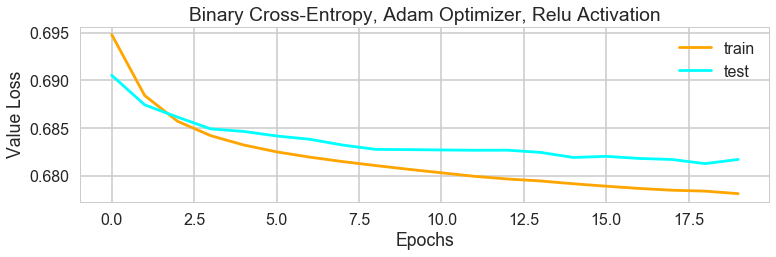

In [80]:
# Display Loss Results of  Binary Cross-Entropy, Adam Optimizer, Relu Activation 
plt.figure(figsize =(11,3))
plt.plot(history__relu.history['loss'], label='train', color = 'orange')
plt.plot(history__relu.history['val_loss'], label='test', color = 'aqua')
plt.legend()
plt.style.use('tableau-colorblind10')
plt.ylabel('Value Loss')
plt.xlabel('Epochs')


plt.title('Binary Cross-Entropy, Adam Optimizer, Relu Activation')
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

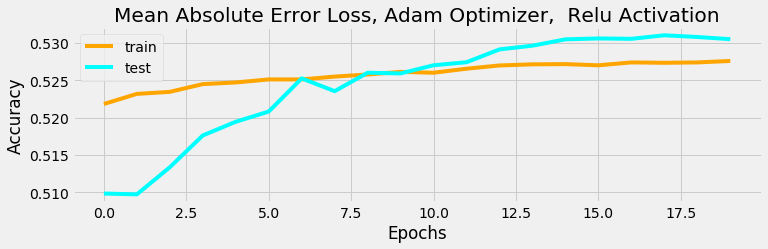

In [34]:
# Display Accuracy Results of  Binary Cross-Entropy, Adam Optimizer, Relu Activation 
plt.figure(figsize =(11,3))
plt.plot(history__relu.history['acc'], label='train', color = 'orange')
plt.plot(history__relu.history['val_acc'], label='test', color = 'aqua')
plt.legend()
plt.style.use('tableau-colorblind10')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')


plt.title('Mean Absolute Error Loss, Adam Optimizer,  Relu Activation')
plt.show

In [78]:
# Model Results of Binary Cross-Entropy, Adam Optimizer, Relu Activation 
print("Model Evaluation Accuracy of Binary Cross-Entropy, Adam Optimizer w/ Relu Activation")
print(model_relu.evaluate(test_X, test_y))
print('Model Summary')
model_relu.summary()

Model Evaluation Accuracy of Binary Cross-Entropy, Adam Optimizer w/ Relu Activation
130823/130823 [==============================] - 10s 77us/step
[0.6816888608958592, 0.5596798728056963]
Model Summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 1, 50)             13000     
_________________________________________________________________
lstm_13 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_14 (Dense)             (None, 64)                3264      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 36,529
Trainable params: 36,529
Non-trainable params: 0
_________________________________________________________________


In [79]:
# Number of Epochs where extended to check for increased Accuracy
# Model Design Binary Cross-Entropy, Adam Optimizer, Relu Activation 
model_SL = Sequential()
model_SL.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model_SL.add(LSTM(50, activation='relu'))
model_SL.add(Dense(64))
model_SL.add(Dense(1))
model_SL.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# early stopping to prevent over-fitting
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience = 5)

# fit network
history_SL = model_SL.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks= [es])



Train on 488206 samples, validate on 130823 samples
Epoch 1/50
 - 62s - loss: 0.6937 - acc: 0.5273 - val_loss: 0.6906 - val_acc: 0.5329
Epoch 2/50
 - 51s - loss: 0.6880 - acc: 0.5415 - val_loss: 0.6878 - val_acc: 0.5449
Epoch 3/50
 - 51s - loss: 0.6850 - acc: 0.5502 - val_loss: 0.6858 - val_acc: 0.5496
Epoch 4/50
 - 54s - loss: 0.6834 - acc: 0.5536 - val_loss: 0.6852 - val_acc: 0.5510
Epoch 5/50
 - 54s - loss: 0.6825 - acc: 0.5555 - val_loss: 0.6843 - val_acc: 0.5540
Epoch 6/50
 - 54s - loss: 0.6818 - acc: 0.5578 - val_loss: 0.6837 - val_acc: 0.5558
Epoch 7/50
 - 56s - loss: 0.6812 - acc: 0.5585 - val_loss: 0.6836 - val_acc: 0.5560
Epoch 8/50
 - 55s - loss: 0.6808 - acc: 0.5596 - val_loss: 0.6831 - val_acc: 0.5562
Epoch 9/50
 - 60s - loss: 0.6804 - acc: 0.5606 - val_loss: 0.6834 - val_acc: 0.5571
Epoch 10/50
 - 53s - loss: 0.6802 - acc: 0.5610 - val_loss: 0.6854 - val_acc: 0.5575
Epoch 11/50
 - 54s - loss: 0.6800 - acc: 0.5616 - val_loss: 0.6846 - val_acc: 0.5571
Epoch 12/50
 - 55s - l

In [10]:

# Model Results of Binary Cross-Entropy, Adam Optimizer, Relu Activation 
print("Model Evaluation Accuracy of Binary Cross-Entropy, Adam Opt w/ Relu Activation")
print(model_SL.evaluate(test_X, test_y))
print('Model Summary')
model_SL.summary()

Model Evaluation Accuracy of Binary Cross-Entropy w/ Relu Activation
130823/130823 [==============================] - 8s 62us/step
[0.682024875368008, 0.5593129648460867]
Model Summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 50)             13000     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                3264      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 36,529
Trainable params: 36,529
Non-trainable params: 0
_________________________________________________________________


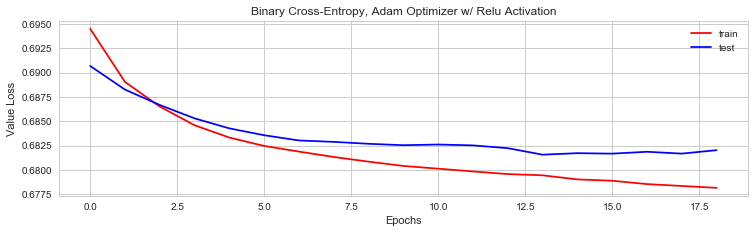

In [17]:
# Display Loss Results of Binary Cross-Entropy, Adam Optimizer, Relu Activation 
plt.figure(figsize =(11,3))
plt.plot(history_SL.history['loss'], label='train', color = 'red')
plt.plot(history_SL.history['val_loss'], label='test', color = 'blue')
plt.legend()
plt.style.use('seaborn-whitegrid')
plt.ylabel('Value Loss')
plt.xlabel('Epochs')


plt.title('Binary Cross-Entropy, Adam Optimizer w/ Relu Activation')
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

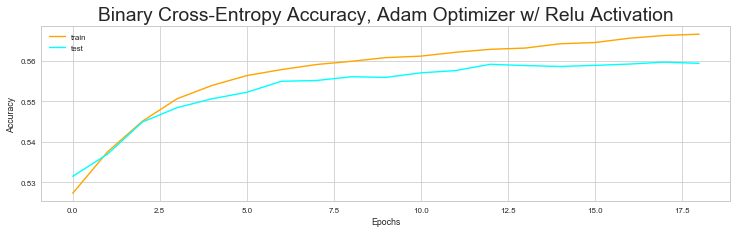

In [77]:
# Display Accuracy Results of Binary Cross-Entropy, Adam Optimizer, Relu Activation 
plt.figure(figsize =(11,3))
plt.plot(history_SL.history['acc'], label='train', color = 'orange')
plt.plot(history_SL.history['val_acc'], label='test', color = 'aqua')
plt.legend()
plt.style.use('seaborn-poster')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')


plt.title('Binary Cross-Entropy Accuracy, Adam Optimizer w/ Relu Activation')
plt.show

Train on 488206 samples, validate on 130823 samples
Epoch 1/15
 - 53s - loss: 0.4776 - acc: 0.5231 - val_loss: 0.4760 - val_acc: 0.5247
Epoch 2/15
 - 50s - loss: 0.4775 - acc: 0.5231 - val_loss: 0.4759 - val_acc: 0.5247
Epoch 3/15
 - 47s - loss: 0.4775 - acc: 0.5231 - val_loss: 0.4759 - val_acc: 0.5247
Epoch 4/15
 - 47s - loss: 0.4775 - acc: 0.5231 - val_loss: 0.4758 - val_acc: 0.5247
Epoch 5/15
 - 55s - loss: 0.4775 - acc: 0.5231 - val_loss: 0.4759 - val_acc: 0.5247
Epoch 6/15
 - 60s - loss: 0.4775 - acc: 0.5231 - val_loss: 0.4760 - val_acc: 0.5247
Epoch 7/15
 - 63s - loss: 0.4775 - acc: 0.5231 - val_loss: 0.4762 - val_acc: 0.5247
Epoch 8/15
 - 64s - loss: 0.4774 - acc: 0.5231 - val_loss: 0.4762 - val_acc: 0.5247
Epoch 9/15
 - 55s - loss: 0.4774 - acc: 0.5231 - val_loss: 0.4761 - val_acc: 0.5247


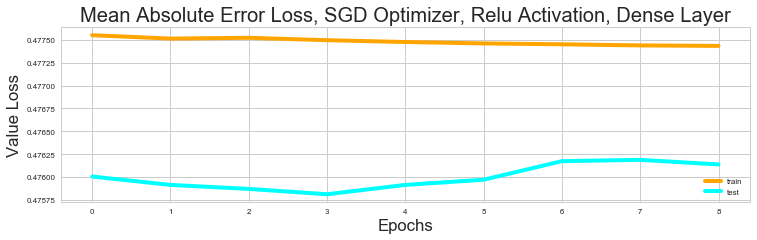

In [71]:
#Loss Function of Mean Absolute Error
model_sgd_dense = Sequential()
model_sgd_dense.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model_sgd_dense.add(LSTM(50, activation='relu'))
model_sgd_dense.add(Dense(64))
model_sgd_dense.add(Dense(1))
model_sgd_dense.compile(optimizer='sgd', loss='mae' , metrics=[ 'accuracy'])
# early stopping to prevent over-fitting
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience = 5)

# fit network
history_sgd_dense = model_sgd_dense.fit(train_X, train_y, epochs=15, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks= [es])


# Display 
plt.figure(figsize =(11,3))
plt.plot(history_sgd_dense.history['loss'], label='train', color = 'orange')
plt.plot(history_sgd_dense.history['val_loss'], label='test', color = 'aqua')
plt.legend()
plt.style.use('tableau-colorblind10')
plt.ylabel('Value Loss')
plt.xlabel('Epochs')


plt.title('Mean Absolute Error Loss, SGD Optimizer, Relu Activation, Dense Layer')
plt.show()

In [72]:
# Model Results of Mean Absolute Error
print("Model Evaluation Accuracy of Mean Absolute Error w/ Relu Activation & Dense Layers")
print(model_sgd_dense.evaluate(test_X, test_y))
print('Model Summary')
model_SL.summary()

Model Evaluation Accuracy of Mean Absolute Error w/ Relu Activation & Dense Layers
130823/130823 [==============================] - 13s 97us/step
[0.47613725647934313, 0.5246707383260574]
Model Summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 50)             13000     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                3264      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 36,529
Trainable params: 36,529
Non-trainable params: 0
_________________________________________________________________


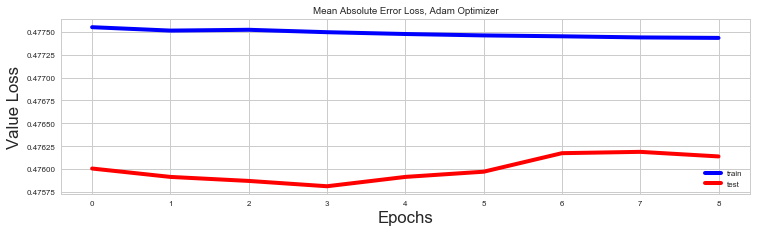

In [73]:
# Display Loss Results of Mean Absolute Error Loss
plt.figure(figsize =(11,3))
plt.plot(history_sgd_dense.history['loss'], label='train', color = 'Blue')
plt.plot(history_sgd_dense.history['val_loss'], label='test', color = 'Red')
plt.legend()
plt.style.use('seaborn-paper')
plt.ylabel('Value Loss')
plt.xlabel('Epochs')


plt.title('Mean Absolute Error Loss, Adam Optimizer')
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

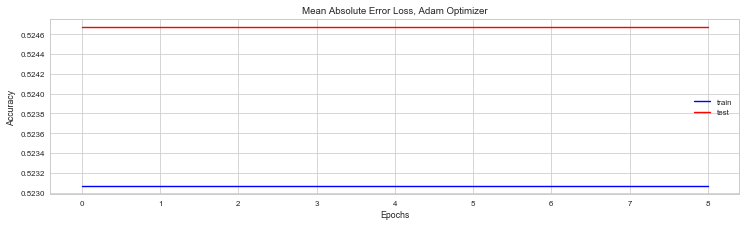

In [74]:
# Display Accuracy Results of Mean Absolute Error
plt.figure(figsize =(11,3))
plt.plot(history_sgd_dense.history['acc'], label='train', color = 'Blue')
plt.plot(history_sgd_dense.history['val_acc'], label='test', color = 'Red')
plt.legend()
plt.style.use('seaborn-paper')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')


plt.title('Mean Absolute Error Loss, Adam Optimizer')
plt.show

In [ ]:
#ARIMA Modeling

In [157]:
#Shorten Time-Series To last year of DataSet
r_df= df.loc['2017-1-1 01:00:00':]

r_df.head()
r_df.shape


(139161, 25)

In [158]:
#Isolate one stock to follow 
aal_df= r_df[r_df['Name'].str.contains("AAL")]


In [82]:
aal_df['Yesterdays_Average'] = df['Yesteday_Vitality'].resample('d').mean()
aal_df['Yesterdays_Market'] = df['Yesterday_Market'].resample('d').mean()

In [83]:
#Take ARIMA Models add shifts together and take average

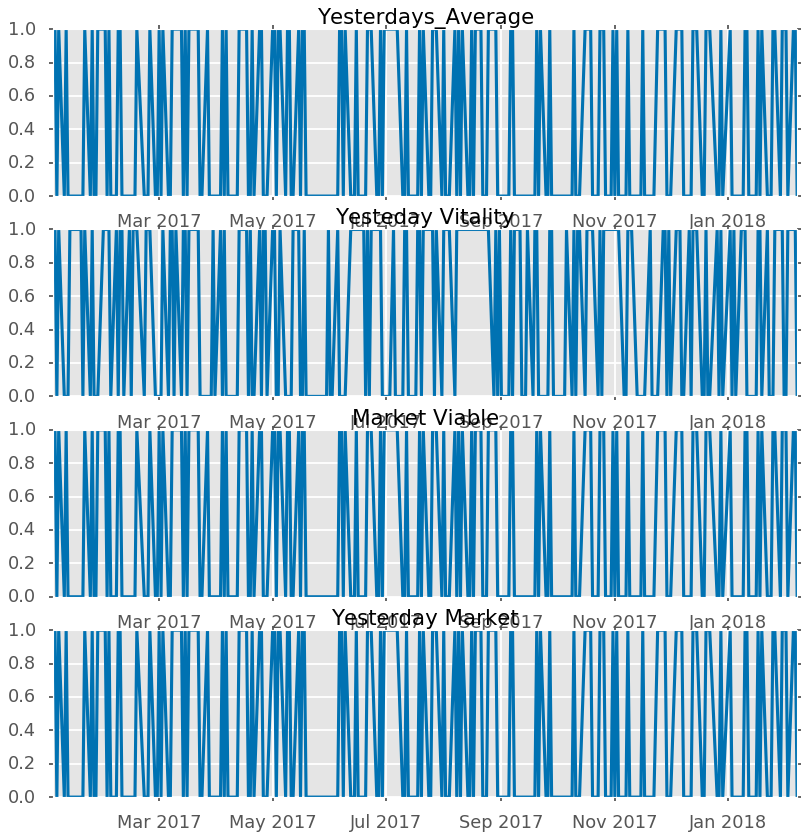

In [84]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=4, figsize=(12, 12))

ax0.plot(aal_df.Yesterday_Market)
ax0.set_title('Yesterdays_Average')
ax1.plot(aal_df.Yesteday_Vitality)
ax1.set_title('Yesteday Vitality')
ax2.plot(aal_df.Yesterdays_Market)
ax2.set_title('Market Viable')
ax3.plot(aal_df.Yesterday_Market)
ax3.set_title('Yesterday Market')




plt.show()



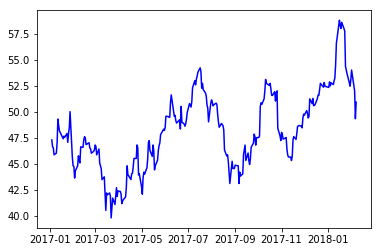

In [88]:
#AAL stock over the last year of data set
plt.plot(aal_df.open, color='blue',label='Original')

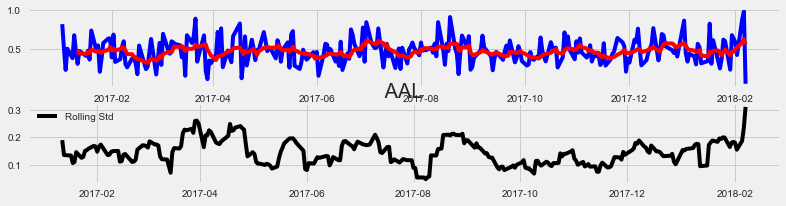

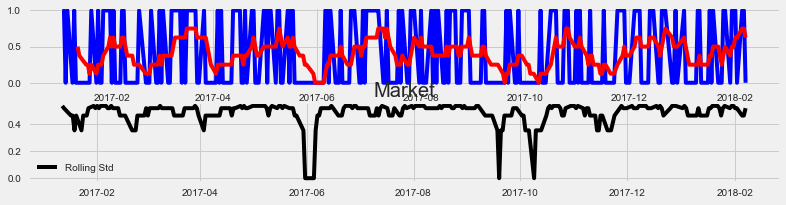

In [65]:
#looking at moment of stock compared to market 
def change_over_time(series, name):
    
    
    fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(12, 3))
    plt.title(name)
    orig = ax0.plot(series, color='blue',label='Original')
    rolmean = series.rolling(window = 8, center = False).mean()
    rolstd = series.rolling(window = 8, center = False).std()
    mean = ax0.plot(rolmean, color='red', label='Rolling Mean')
    std = ax1.plot(rolstd, color='black', label = 'Rolling Std')
    #ax0.title('Original')
    plt.legend(loc='best')
    
    #ax1.title('Standard Deviation')
    plt.show(block=False)
    print (' ')
    
    return
change_over_time(aal_df.Yesterdays_Average , ' AAL ')
change_over_time(aal_df.Yesterdays_Market, 'Market')

In [92]:
#Testing for Stationarity 
from statsmodels.tsa.stattools import adfuller

def stationarity(series):
    dftest = adfuller(series)
    Series = series

    # Extract and display test results in a user friendly manner
    dfoutput =pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dftest)
    print ('Results of Dickey-Fuller Test:')
    print(dfoutput)
    return
#stationarity(aal_df.open)
print(' ')
print('AAL Stock p-value is less than the critical value hence the null hypothosis cannnot ')
print('be rejected hence there is a unit root or is stationary.')
yy = stationarity(aal_df.Yesterdays_Average)
print('yy')
print(' ')


print(' ')
print('Market is stationary due to p-value being greater then the critical')

stationarity(aal_df.Yesterdays_Market)


 
AAL Stock p-value is less than the critical value hence the null hypothosis cannnot 
be rejected hence there is a unit root.
(-16.521322103846753, 2.0629829957496465e-29, 0, 276, {'1%': -3.4542672521624214, '5%': -2.87206958769775, '10%': -2.5723807881747534}, -215.62651293685968)
Results of Dickey-Fuller Test:
Test Statistic                -1.652132e+01
p-value                        2.062983e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.760000e+02
Critical Value (1%)           -3.454267e+00
Critical Value (5%)           -2.872070e+00
Critical Value (10%)          -2.572381e+00
dtype: float64
yy
 
 
Market is stationary due to critical value
being more than test statistic
(-5.30245668542814, 5.411856131085015e-06, 8, 268, {'1%': -3.454988209954765, '5%': -2.8723857312734613, '10%': -2.572549407997327}, 368.8446328997795)
Results of Dickey-Fuller Test:
Test Statistic                  -5.302457
p-value                          0.000005
#Lags Used    

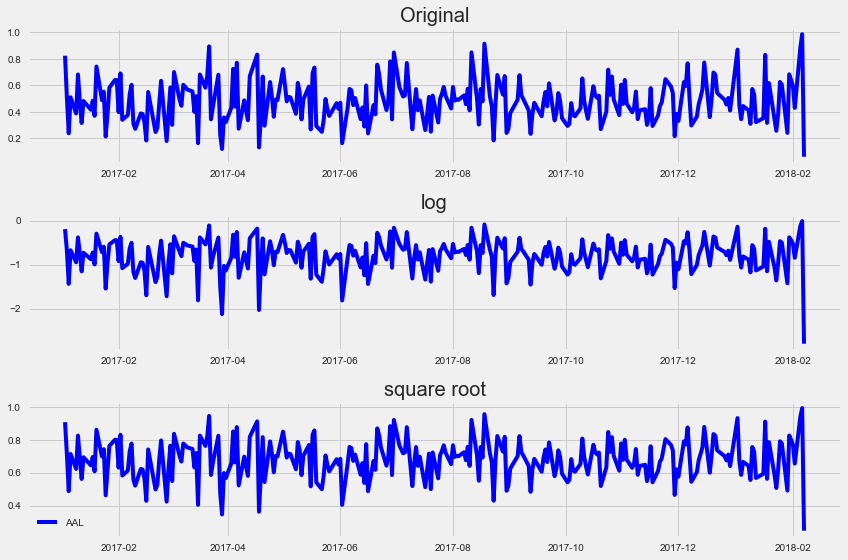

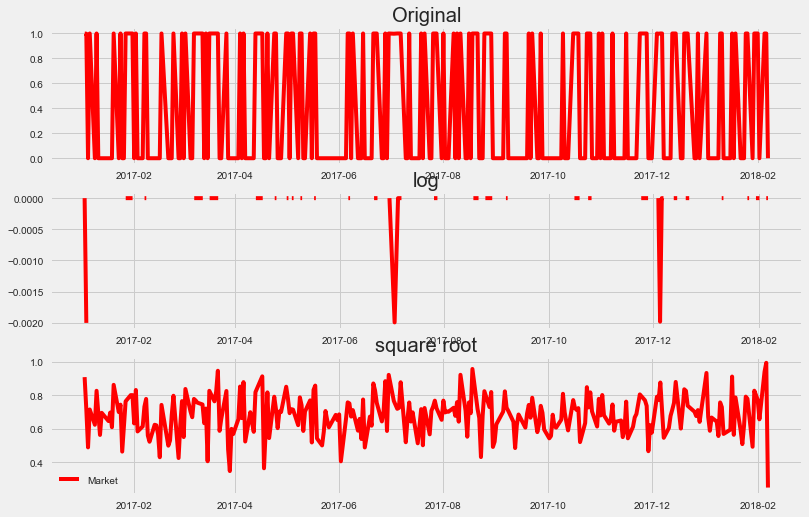

In [95]:
#transforming time series for ARIMA Modeling
#log and square root 
ts = aal_df.Yesterdays_Average
ts_log = np.log(ts)
ts_sqrt= np.sqrt(ts)

m_ts = aal_df.Yesterdays_Market
m_ts_log = np.log(m_ts)
m_ts_sqrt= np.sqrt(m_ts)

fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(12, 8))

ax0.plot(ts, color = 'blue' , label = 'AAL')

ax0.set_title('Original')
ax1.plot(ts_log, color = 'blue' , label = 'AAL')
ax1.set_title('log')
ax2.plot(ts_sqrt, color = 'blue' , label = 'AAL')
ax2.set_title('square root')
plt.legend(loc='best')
fig.tight_layout()

fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(12, 8))
ax0.plot(m_ts, color = 'red' , label = 'Market')
ax0.set_title('Original')
ax1.plot(m_ts_log ,color = 'red' , label = 'Market')
ax1.set_title('log')
ax2.plot(ts_sqrt, color = 'red' , label = 'Market')
ax2.set_title('square root')
plt.legend(loc='best')
plt.show()



In [ ]:
#log and square root 
ts = aal_df.Yesterdays_Average
ts_log = np.log(ts)
ts_sqrt= np.sqrt(ts)

fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(12, 8))

ax0.plot(ts)
ax0.set_title('AAl stock')
ax1.plot(ts_log)
ax1.set_title('log')
ax2.plot(ts_sqrt)
ax2.set_title('square root')

fig.tight_layout()
plt.show()




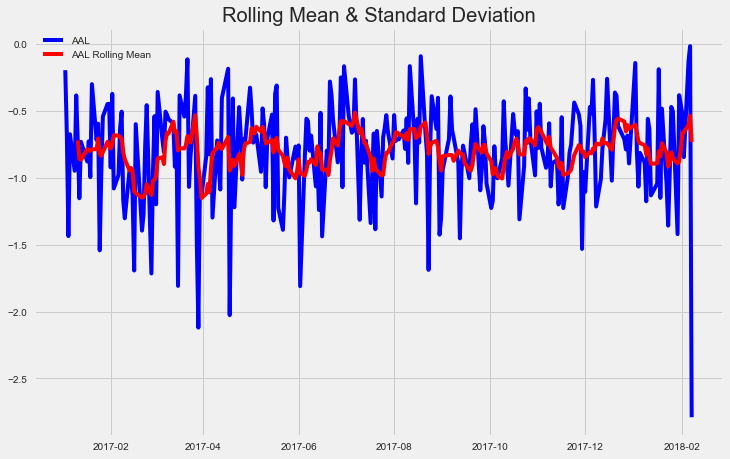

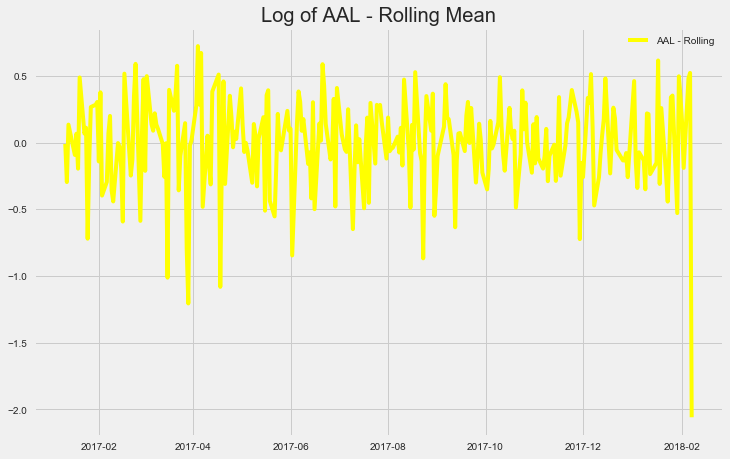

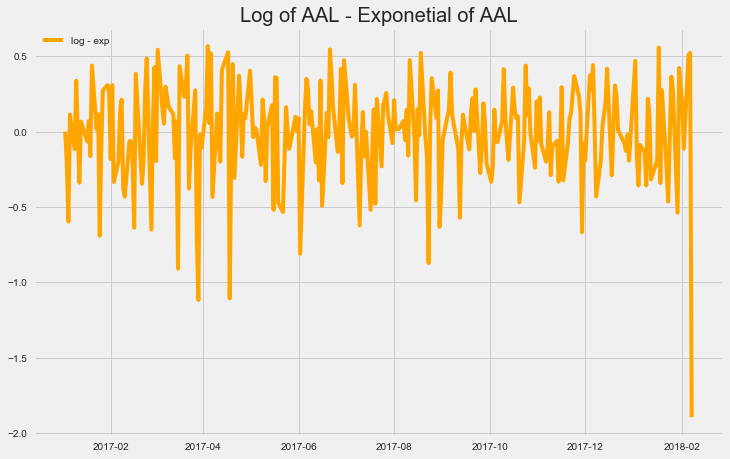

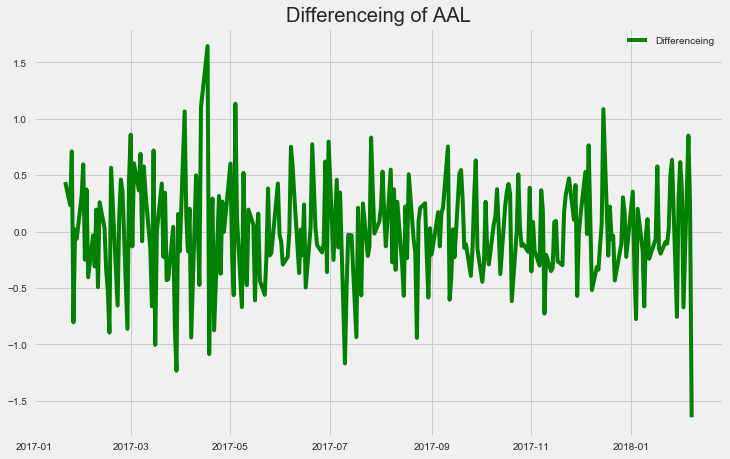

In [71]:
rolmean = np.log(ts).rolling(window = 7).mean()
fig = plt.figure(figsize=(11,7))
orig = plt.plot(np.log(ts), color='blue',label='AAL')
mean = plt.plot(rolmean, color='red', label='AAL Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)
data_minus_rolmean = np.log(ts) - rolmean
data_minus_rolmean.dropna(inplace=True)
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_rolmean, color='yellow',label='AAL - Rolling')
plt.legend(loc='best')
plt.title('Log of AAL - Rolling Mean')
plt.show(block=False)
exp_rolmean = np.log(ts).ewm(halflife = 4).mean()
data_minus_exp_rolmean = np.log(ts) - exp_rolmean
data_minus_exp_rolmean = data_minus_exp_rolmean.dropna()
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_exp_rolmean, color='orange',label='log - exp')
plt.legend(loc='best')
plt.title('Log of AAL - Exponetial of AAL')
plt.show(block=False)
data_diff = data_minus_exp_rolmean.diff(periods=12)
data_diff = data_diff.dropna()
fig = plt.figure(figsize=(11,7))
plt.plot(data_diff, color='green',label='Differenceing')
plt.legend(loc='best')
plt.title('Differenceing of AAL')
plt.show(block=False)

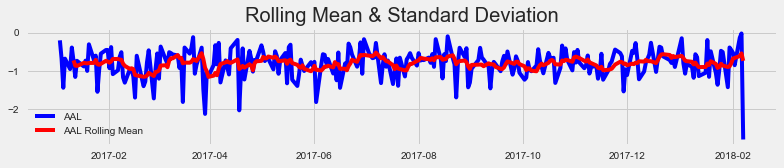

In [76]:
rolmean = np.log(ts).rolling(window = 7).mean()
fig = plt.figure(figsize=(12,2))
orig = plt.plot(np.log(ts), color='blue',label='AAL')
mean = plt.plot(rolmean, color='red', label='AAL Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

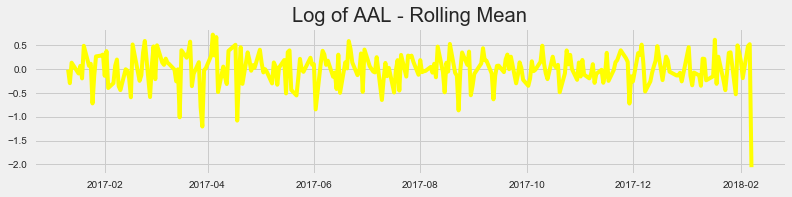

In [79]:
data_minus_rolmean = np.log(ts) - rolmean
data_minus_rolmean.dropna(inplace=True)
fig = plt.figure(figsize=(12,2.5))
plt.plot(data_minus_rolmean, color='yellow',label='AAL - Rolling')

plt.title('Log of AAL - Rolling Mean')
plt.show(block=False)

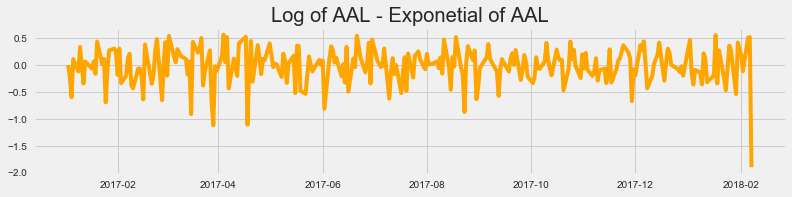

In [81]:
exp_rolmean = np.log(ts).ewm(halflife = 4).mean()
data_minus_exp_rolmean = np.log(ts) - exp_rolmean
data_minus_exp_rolmean = data_minus_exp_rolmean.dropna()
fig = plt.figure(figsize=(12,2.5))
plt.plot(data_minus_exp_rolmean, color='orange',label='log - exp')
plt.title('Log of AAL - Exponetial of AAL')
plt.show(block=False)

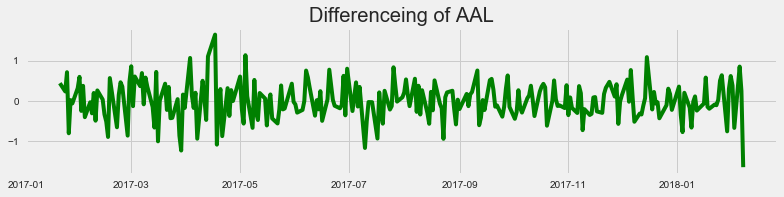

In [82]:
data_diff = data_minus_exp_rolmean.diff(periods=12)
data_diff = data_diff.dropna()
fig = plt.figure(figsize=(12,2.5))
plt.plot(data_diff, color='green',label='Differenceing')
plt.title('Differenceing of AAL')
plt.show(block=False)

In [83]:
def stationarity(series):
    dftest = adfuller(series)
    Series = series

    # Extract and display test results in a user friendly manner
    dfoutput =pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dftest)
    print ('Results of Dickey-Fuller Test:')
    print(dfoutput)
    return
stationarity(data_diff)

(-6.776216323920775, 2.5668217474515564e-09, 16, 248, {'1%': -3.4569962781990573, '5%': -2.8732659015936024, '10%': -2.573018897632674}, 247.77408480085285)
Results of Dickey-Fuller Test:
Test Statistic                -6.776216e+00
p-value                        2.566822e-09
#Lags Used                     1.600000e+01
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


In [ ]:
df = pd.read_csv('aapl.csv',delimiter=',',usecols=['Date','Open','High','Low','Close'])
df.Date = pd.to_datetime(df.Date)
df['Mean'] = (df.High + df.Low )/2.0

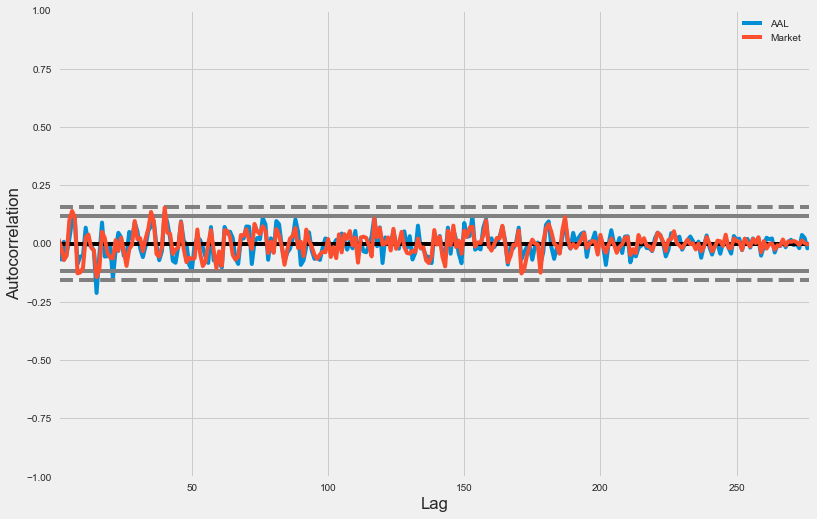

In [90]:
#Autocorrelations
plt.figure(figsize=(12,8))
pd.plotting.autocorrelation_plot(aal_df.Yesterdays_Average, label = 'AAL')
pd.plotting.autocorrelation_plot(aal_df.Yesterdays_Market, label = 'Market')
plt.legend()


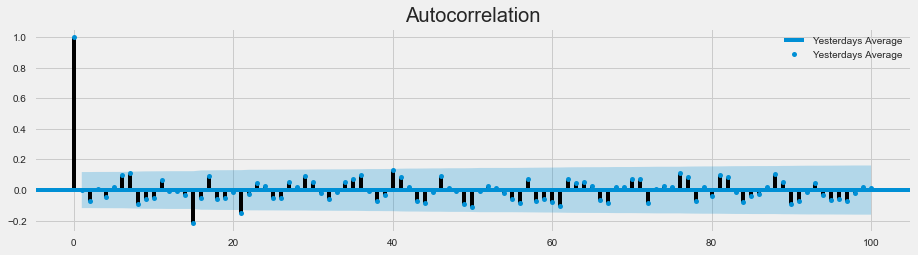

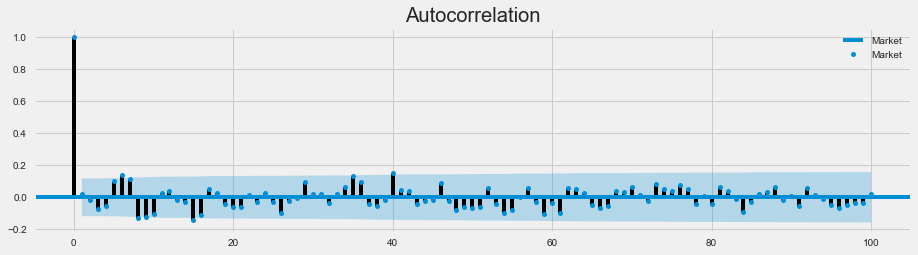

In [99]:
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 14, 3.5

plot_acf(aal_df.Yesterdays_Average, lags = 100, label = 'Yesterdays Average')
plt.legend(loc = 'best')
plot_acf(aal_df.Yesterdays_Market, lags = 100, label = 'Market')
plt.legend(loc='best')


Test Mean Squared Error (smaller the better fit): 0.034


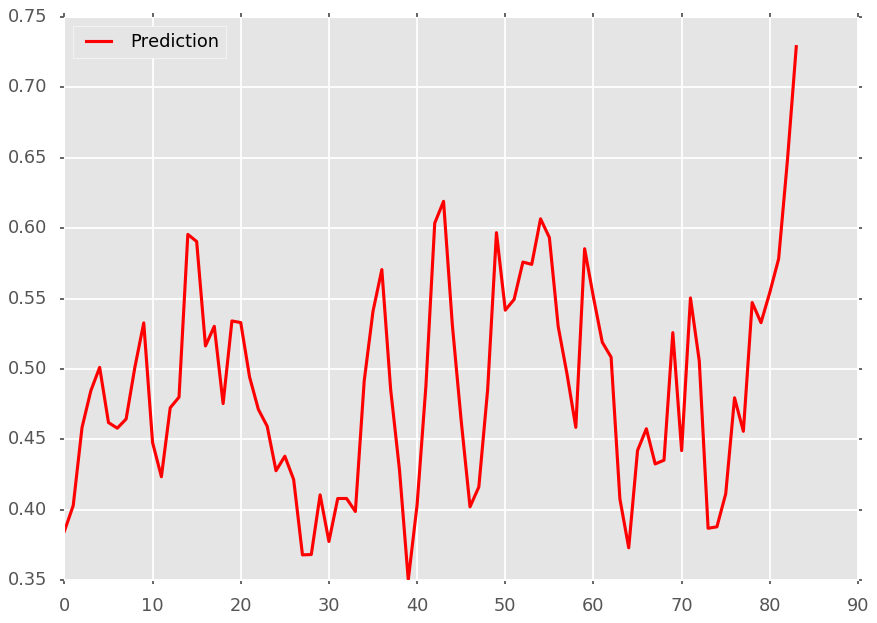

In [85]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")
#Function that calls ARIMA model to fit and forecast the data
def StartARIMAForecasting(Actual, P, D, Q):
    model = ARIMA(Actual, order=(P, D, Q))
    model_fit = model.fit(disp=0)
    prediction = model_fit.forecast()[0]
    return prediction
    
#Get exchange rates
ActualData = aal_df.Yesterdays_Average
#Size of exchange rates
NumberOfElements = len(ActualData)

#Use 70% of data as training, rest 30% to Test model
TrainingSize = int(NumberOfElements * 0.7)
TrainingData = ActualData[0:TrainingSize]
TestData = ActualData[TrainingSize:NumberOfElements]

#new arrays to store actual and predictions
Actual = [x for x in TrainingData]
Predictions = list()


#in a for loop, predict values using ARIMA model
for timepoint in range(len(TestData)):
    ActualValue =  TestData[timepoint]
    #forcast value
    Prediction = StartARIMAForecasting(Actual, 3,1,0)    
    #print('Actual=%f, Predicted=%f' % (ActualValue, Prediction))
    #add it in the list
    Predictions.append(Prediction)
    Actual.append(ActualValue)

#Print MSE to see how good the model is
Error = metrics.mean_squared_error(TestData, Predictions)
print('Test Mean Squared Error (smaller the better fit): %.3f' % Error)
# plot
#plt.plot(TestData)
plt.plot(Predictions, color='red', label = 'Prediction')
plt.legend(loc='best')
#plt.plot(aal_df.Yesterdays_Average, color ='blue')
#plt.show()


model.score(

Text(0, 0.5, 'Price')

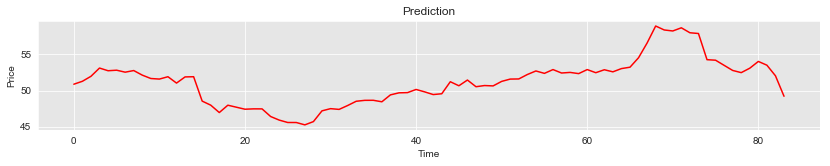

In [295]:
plt.figure(figsize=(14,2))
plt.plot(Predictions, color='red', label = 'Prediction')
plt.title('Prediction')
plt.xlabel('Time')
plt.ylabel('Price')

277


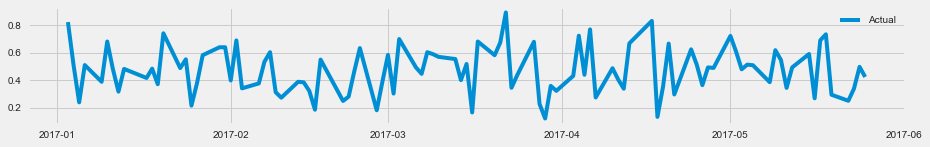

In [106]:
plt.figure(figsize=(14,2))
plt.plot(aal_df.Yesterdays_Average.iloc[:100], label = 'Actual')
plt.legend(loc ='best')
print(len(aal_df.Yesterdays_Average))

Text(0, 0.5, 'Price')

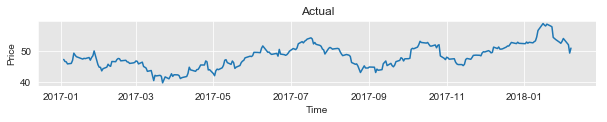

In [296]:
plt.figure(figsize=(10,1.2))
plt.plot(aal_df.open, label = 'Actual')
plt.title('Actual')
plt.xlabel('Time')
plt.ylabel('Price')

In [133]:
print (len(TrainingData))
print(len(aal_df.open))
print(len(TestData))
#TrainingData, TestData

193
277
84


In [ ]:
plt.figure(figsize=(10,1.5))
plot_acf(aal_df.Rolling_Market, lags = 100, label = 'Market')
plt.title('Market Autocorrelation')

In [128]:
from statsmodels.tsa.stattools import adfuller, acf
results = adfuller(aal_df.open)
results


(-2.005218628333457,
 0.2842896108502123,
 0,
 276,
 {'1%': -3.4542672521624214,
  '5%': -2.87206958769775,
  '10%': -2.5723807881747534},
 696.8060388150036)

In [127]:
ac= aal_df.open.autocorr()
ac

0.969267306919236

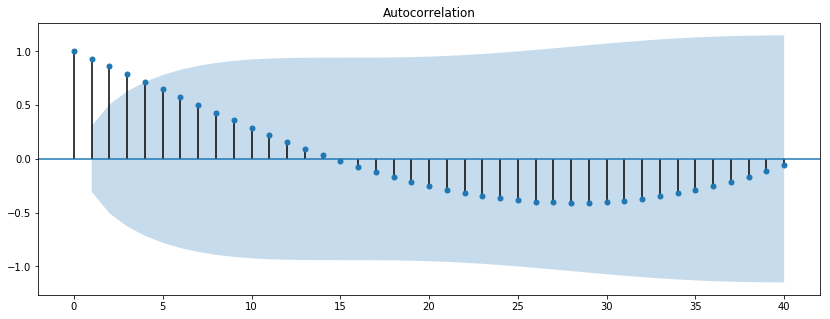

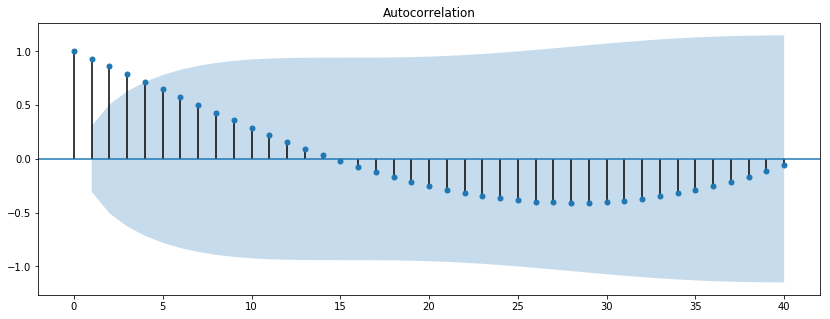

In [131]:
acf = acf(aal_df.open)
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(acf)